# Jupyter Notebookでいじって学ぶTensorFlow - MNIST For ML Beginners

## 概要

この記事は、TensorFlowのチュートリアル"MNIST For ML Beginners"をJupyter Notebookで動かしてみるための記事です。

qiita2notebookというツールを使って、この記事をJupyter Notebookに変換することができます。
ぜひNotebook形式でコードをいじりながら試してみてください。

* [qiita2notebook - Qiitaの記事をJupyter Notebook化してちょっといじって実行する - Qiita](http://qiita.com/oimou/items/efcbcc32b2d9cf9297e4)

## 準備

* Python 2.7
* Jupyter Notebook
* TensorFlow 0.9
* Matplotlib
* Numpy

## 必要なライブラリを読み込もう

必要なライブラリをimportしておきます。

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

/Users/yahata/.pyenv/versions/2.7.10/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## MNIST画像を読み込もう

MNISTは、手書き文字の画像です。機械学習によく使われます。

MNISTのデータを読み込みます。
最初はダウンロードに少し時間がかかります。

In [2]:
from tensorflow.contrib.learn.python.learn.datasets import mnist as mnist_loader

mnist = mnist_loader.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


どんな画像が入っているか見てみましょう。

訓練データの総数: 55000
テストデータの総数: 10000


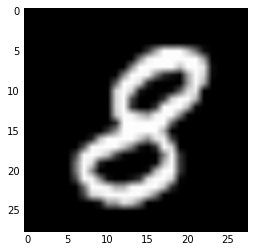

In [3]:
train_images = mnist.train.images
test_images = mnist.test.images

print("訓練データの総数: %s" % (len(train_images)))
print("テストデータの総数: %s" % (len(test_images)))

plt.imshow(train_images[5].reshape([28, 28]))
plt.gray()

ダウンロードデータは2つの部分に分けられます。55,000点の訓練データ(mnist.train)と10,000点のテストデータ(minist.test)です。

全てのMNISTデータは、手書きのデジタル画像とそれに対応するラベルのデータ、の2つの要素から成り立ちます。ここでは手書き画像をxs、ラベルデータをysと呼びます。
(ex, mnist.train.imagesとmnist.train.labels)

それぞれの手書き画像は
28 pixels × 28 pixels = 784個の数字
つまり数字の列(ベクトル)にしてしまっているわけです。

これは２次元の情報を捨ててしまっていることに対応しています。最高難度の手法ではこの2次元の情報も組み込みますが、今回はここまで考えません。

以上の結果、mnist.train.imagesはテンソル(≒ n次元行列 )となり、その形は[60000,784]です。
![スクリーンショット 2015-11-21 2.02.40.png](https://qiita-image-store.s3.amazonaws.com/0/72840/d52ea9c3-7bf4-7036-b4f4-a1833665b9d7.png)

対応するラベルデータは、"one-hot ベクトル"として表現します。
ex, 
0 -> [1,0,0,0,0,0,0,0,0,0,0] 
3 -> [0,0,0,1,0,0,0,0,0,0,0] 
つまりmnist.train.labelsは[5500,10]の配列です。
![スクリーンショット 2015-11-21 2.08.38.png](https://qiita-image-store.s3.amazonaws.com/0/72840/853edea6-a81f-3d3f-e813-74b57b158d75.png)

## モデルを定義しよう
効率的なpythonによる計算を行うために、私たちはたいていNumpyなどの、重い計算をpythonの外で行わせるライブラリを利用します。しかし、pythonに戻ってくるときに大きな計算コストがかかってしまいます。もしGPUや異なる並列計算を行いたい場合、これらは非常に好ましくありません。

TensorFlowは、一つの重い命令をpythonから独立に行わせる代わりに、関連する命令のグラフ全てをpythonの完全に外側で記述することを可能にしました。

overhead .. ハードウェアの管理やプログラム管理にかかるコスト


先に述べたような相互に関連する命令をシンボリック(象徴的)な変数を操作することで記述します。



In [4]:
x = tf.placeholder("float",[None,784])


xは特定にの値ではなく、それはplaceholderと呼ばれます。TensorFlowに計算を実行しろと頼むときに入力する値です。

MNIST画像の入力数値は784次元ベクトルに変換されました。これらを[None, 784]の2次元テンソルとして表現します。

他にもweightやbiasesもモデルには必要です。このようなときにVariableを用います。Variableとは変更可能なテンソルで、TensorFlowの相互作用する命令のグラフに"住んで"います。



In [5]:
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))


今回はWとbを、0しかもっていないようなVariableとして作りました。これからW,bを学習させるので、初期値が何であったかは大して問題ではありません。

こうしてモデルを実行できます！



In [6]:
y = tf.nn.softmax(tf.matmul(x,W)+b)

tf.matmul(x,W)でxとWの掛け算をとり、それにbを加え、その結果をtf.nn.softmaxでSoftmax関数に代入していると思われます。xを2次元テンソルとしていたのはWとの掛け算が取れるからです。
(おそらく matmul = matrix multiple)

## モデルを訓練しよう

機械学習としてなにが良いモデル化を定量的に評価するために誤差関数を用います。今回はcross-entropyと呼ばれる誤差関数を用います。

$$ H_{y'}(y) = -\sum_i y'_i \log(y_i) $$

ここでyは今回予測した結果の確率分布で、y'が真の分布です。

cross-entropyを実行するために、まずは、正しい正解を入力するための新しいplaceholderを加える必要があります。

In [7]:
y_ = tf.placeholder("float",[None,10])


そしてcross-entropyを実行できます。



In [8]:
cross_entropy = -tf.reduce_sum(y_*tf.log(y))


tf.log(y)でyの各要素の対数を計算し、y_の各値との掛け算を計算し、最後にtf.reduce_sumでテンソルの全ての要素を足し合わせています。

TensorFlowでは学習は簡単に行えます。TensorFlowは自身の計算の全グラフを知っているので、自動的にbackpropagationアルゴリズムを使うことができるのです。backpropagationアルゴリズムは効率的に、どのように変数が最小化するべき誤差関数に影響するかを明らかにしてくれます。



In [9]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)


今回は、TensorFlowにcross_entropyを、Gradient descentアルゴリズムを用いて、0.01のlearning rateで最小化するよう命令しています。gradient descentはシンプルな手続きで、TensorFlowはシンプルにそれぞれの変数を、誤差が小さくなる方向に少しだけ変更してくれます。
しかしTensorFlowはたくさんの最適化アルゴリズムを備えていて、それらを使うことは非常に簡単です。

モデルを訓練させる前に一つだけ、設定した変数を初期化するための命令を加えなければなりません。(*まだ実行はされていない！)



In [10]:
init = tf.initialize_all_variables()


ようやく、セッションを始めることができます。変数を初期化する命令を実行しましょう。

`tf.InteractiveSession()`はTensorFlowのコードをJupyterで実行するのに便利な命令です。 

In [11]:
sess = tf.InteractiveSession()
sess.run(init)

訓練を1000回繰り返します。
`n_train`の値を変えてみると訓練回数が変わります。ここでの訓練パラメータが後の分類精度にも影響することが分かるはずです。

**※ 注意：訓練パラメータを変更して再度訓練を行う場合は、毎回 tf.initialize_all_variables() を呼んで、学習済みの変数を初期化してから実行してください！**

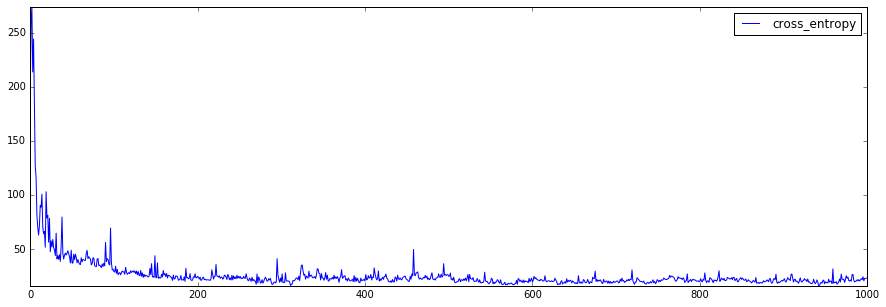

In [12]:
# 訓練パラメータ
n_train = 1000
n_batch = 100

# グラフ描画用
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
xvalues = np.arange(n_train)
yvalues = np.zeros(n_train)
lines, = ax.plot(xvalues, yvalues, label="cross_entropy")

for i in range(n_train):

    # バッチ学習
    batch_xs, batch_ys = mnist.train.next_batch(n_batch)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    
    # グラフ描画用
    yvalues[i] = cross_entropy.eval(feed_dict={x: mnist.test.images[0:100], y_: mnist.test.labels[0:100]})
    lines.set_data(xvalues, yvalues)
    ax.set_ylim((yvalues.min(), yvalues.max()))
    plt.legend()
    plt.pause(.00001)

ループの各ステップで、用意した訓練データセットから100個のランダムなデータ点の"バッチ"を取得しています。そしてtrain_stepを実行し、各バッチデータを与え、placeholderを変更していきます。

これをバッチ学習と呼びます。

ランダムなデータから成る"小さなバッチ"を使う手法は確率的訓練(stochastic training)と呼ばれていて、今回の場合はstochastic gradient descentです。 // 本当？

さて、学習された$W$の中身を見てみましょう。

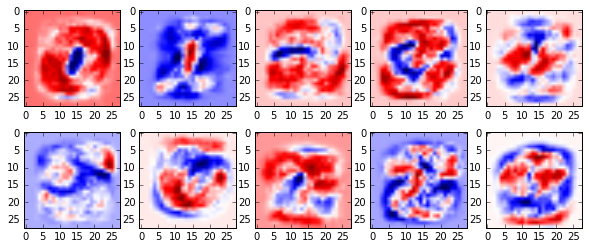

In [13]:
w = W.eval().T
fig = plt.figure(figsize=(10, 4))

for i in range(10):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(w[i].reshape([28, 28]), cmap="seismic")

左上から順に0~9まで並んでいます。

赤い部分が文字の特徴を強めるピクセル、青い部分が文字の特徴を弱めるピクセルです。

※ [colormap](http://matplotlib.org/examples/color/colormaps_reference.html)を変えると色を変えることができます。

## 作成したモデルを評価しよう

まず初めに、正しく予測を行ったものを把握します。tf.argmaxは非常に便利な関数で、いくつかの軸に沿ってテンソルが最も大きい要素をもっているその値を返してくれます。例えば、tf.argmax(y,1)は各インプットに対して最も確からしいラベルを返し、tf.argmax(y_,1)は正解のラベルを返します。そしてtf.equalで私たちの予測が当たっていたかを判定することができます。



In [14]:
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_,1))


この結果として、ブール値のリストが返されます。扱いやすいようにFloat値の数字に変換して、平均を取ります。例えば、[True, False, True, True]は[1,0,1,1]となり平均は0.75です。



In [15]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

最後に、私たちはテストデータに対する予測の正答率を訪ねます

In [16]:
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9187



この結果は91%程度になるでしょう。














## 作成したモデルを使って分類してみよう

モデルを実際に使ってみましょう。

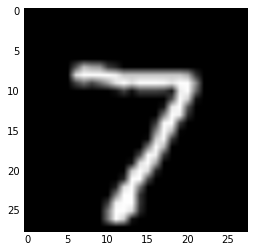

In [17]:
plt.imshow(test_images[0].reshape([28, 28]))
plt.gray()

分類モデルに上の画像を与えて、分類結果を見てみましょう。

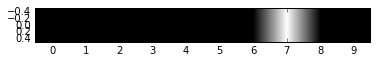

In [18]:
result = y.eval(feed_dict={x: [test_images[0]]})

plt.xticks(range(0, 10))
plt.imshow(result)

該当する数字の部分が白くなっているはずです。
きちんと分類できているでしょうか？画像を変えて色々試してみてください。